In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy import interpolate
from functools import partial
import json
from glob import glob

import os

In [3]:
from dataprocess.generator import *

In [4]:
def get_converter(field:str):
    if field == "inst":
        keys = ["S", "T", "L", "V", "M"]
    elif field == "condition":
        keys = ["F", "S", "D", "A", "N"]
    elif field == "posture":
        keys = ["S", "D", "P", "L", "F", 
                "C", "H", "E", "T", "U"]
    else:
        raise ValueError(field)

    return partial(_concat, keys=keys)

def _concat(value, keys=None):
    """concatenate strings"""
    code =""
    for s in keys:
        if s in value:
            code += s
        else:
            code += "X"
    return code

In [120]:
concat_inst = get_converter("inst")
concat_condition = get_converter("condition")
concat_posture = get_converter("posture")

In [121]:
clip_dir = "/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/"
clip_list = glob(clip_dir+"*.mp4")
clip_list.sort()
clip_list_fn = [cl.split("/")[-1] for cl in clip_list]

In [122]:
file_sizes_Bytes = [os.path.getsize(cc) for cc in clip_list]

In [123]:
print(f"Total file size {np.sum(file_sizes_Bytes)/1024/1024/1024:.2f}GB")

Total file size 1.08GB


In [124]:
## Variables below are to be read from csv file ##
username = "hoseung"
email = "hschoi@dinsight.ai"
subject = 1
medical = 1
age = 34
glasses = "no"
cosmetic= "no"
mask = "no"
ver  = len(clip_list)
rev = 0
date = "2022-06-08"
loc = "S101"
inst = "S"
condition = "FSDAN"
posture = "SDPLFCXETU"
n_rgb = len(clip_list_fn)
n_ir = 0
n_point = len(clip_list_fn)
n_head = len(clip_list_fn)
n_gaze = len(clip_list_fn)
tsize_rgb = np.sum(file_sizes_Bytes)/1024/1024/1024
tsize_ir = 0
tsize_point = 2.1
tsize_head = 2.1
tsize_gaze = 2.1
tsize_d_cam = 0.8
tsize_d_disp = 0.8
######################################




x = {
    "id": {"subject":subject, "medical":medical},
    "age":age, 
    "glasses":glasses, 
    "cosmetic":cosmetic, 
    "mask":mask, 
    "ver":ver, 
    "date":date, 
    "loc":loc, 
    "inst":concat_inst(inst), 
    "condition":concat_condition(condition),
    "posture":concat_posture(posture),
    "rev":rev,
    "image": {"format": {"rgb": "mp4","ir": "mp4", "point":"csv", "head":"csv", "gaze":"csv", 
                         "d_cam":"csv", "d_disp":"csv"},
                "spec":{"rgb.w":1920, "rgb.h":1080, "ir.w":1920, "ir.h":1080, 
                         "point":"yyyy-mm-dd,hh:mm:ss,x,y",
                         "head":"yyyy-mm-dd,hh:mm:ss,deg,deg,deg",
                         "gaze":"yyyy-mm-dd,hh:mm:ss,deg,deg,deg",
                         "d_cam":"yyyy-mm-dd,hh:mm:ss,cm",
                         "d_disp":"yyyy-mm-dd,hh:mm:ss,cm"},
                "total_size":{"rgb":tsize_rgb, "ir":tsize_ir, "point":tsize_point, "head":tsize_head,
                              "gaze":tsize_gaze, "d_cam":tsize_d_cam, "d_disp":tsize_d_disp},
                "total_count":{"rgb":n_rgb, "ir":n_ir, "point":n_point, "head":n_head, "gaze":n_gaze}
             },
    "task":{
        "name":"NIA_EYE",
        "created":"yyyy-mm-dd,hh:mm:ss", 
        "updated":"yyyy-mm-dd,hh:mm:ss",
        "username":username, 
        "email":email},
    "filelist":clip_list_fn
}

In [125]:
# Dump json file
fn = "test2.json"
with open(fn, "w") as f:
    json.dump(x, f)

Eye-tracker, 얼굴 지향각, 시선 각, 카메라-촬영자 거리, 카메라-디스플레이 거리   
각각은 영상의 매 프레임마다 측정값이 제공 됨.  

이번에는 가짜 값을 만들어냄.

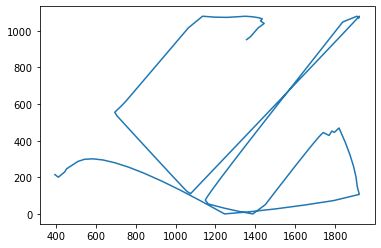

In [11]:
p = Particle(1920, 1080, 500)
xx, yy = p.random_move(max_dt=30, dt_stop=15, max_acc=10, min_acc=5)
plt.plot(xx, yy)

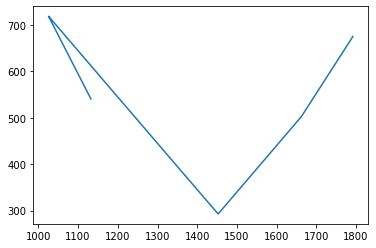

In [12]:
p = Particle(1920, 1080, 500)
xx, yy = p.random_move(max_dt=300, dt_stop=1, max_acc=6, min_acc=2)
plt.plot(xx, yy)

#### ISSUE
1. 화면에 표시되는 순간과 관찰자의 눈이 화면을 찾아가는 시간의 차이가 발생함
2. 그 차이가 사람에 따라 다를 것 (빠릿빠릿 vs 느릿느릿)

gaze pose는 각도이므로 점에서 각도로 다시 변환 해야함. 

In [13]:
def point_to_degree(xpos, ypos, d_cam, d_disp, ):
    """transformation이 너무... 많은데..?? 
    """

In [126]:
import cv2

# count the number of frames of the video
conditions = ["F", "S", "D", "A", "N"]
postures = ["S", "D", "P", "L", "F", "C", "H", "E", "T", "U"]
display = ["S", "T", "L", "V", "M"]

wdir = "./"

for fn_clip in clip_list:
    file_name = fn_clip.split("/")[-1]
    display, posture, condition, orientation = file_name.split(".mp4")[0].split("_")
    cap = cv2.VideoCapture(fn_clip)
    if not cap.isOpened():
        continue
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(display, posture, condition, orientation)
    fake = Fake_generator(wdir, nframes, 1920, 1080, display, posture, condition, orientation)
    dist = 35 # 정하고 하는거 아님
    fake.gen_d_disp(dist)
    fake.gen_d_cam(dist)
    fake.gen_head()
    fake.gen_pose_d()
    fake.gen_gaze_eye_trakcer()
    fake.save_all()

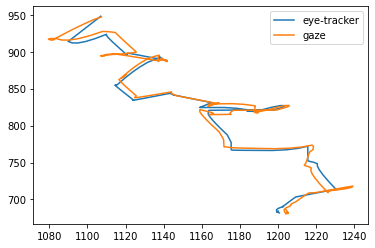

In [404]:
fake = Fake_generator('./', 500, 1920, 1080, condition='no_interest')

fake.gen_d_disp(80)
fake.gen_d_cam(80)
fake.gen_gaze_eye_trakcer()
fake.gen_head()
fake.gen_pose_d()
fake.gen_gaze_eye_trakcer()

fig, ax = plt.subplots()
ax.plot(fake.point['point_x'], fake.point['point_y'], label="eye-tracker")
ax.plot(fake.gaze_x,  fake.gaze_y, label="gaze")
ax.legend()
plt.show()

In [376]:
fake.disp_pose.keys()

dict_keys(['roll', 'pitch', 'yaw'])

In [47]:
# 저장만 하면 됨... 
# 파일 이름 확인하고 
# 포멧 확인해서 
# CSV로. 

'/home/hoseung/Dropbox/DeepInsight/2022/NIA/예제/FHD/핸드폰_태만_80cm_FHD.mp4'

In [32]:
clip_list

['/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_A_H1.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_A_H2.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_A_V.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_D_H1.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_D_H2.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_D_V.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_F_H1.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_F_H2.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_F_V.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_S_H1.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_S_H2.mp4',
 '/home/hoseung/Dropbox/DeepInsight/2022/NIA/1Cycle/FHD/done/mobile_C_S_V.mp4',
 '/home/hoseung/Dropbox/DeepInsi